# ch 17_9 Simple DNN

이번 챕터에서는 이론으로 배운 딥러닝 모델을 간단히 구현해보겠습니다. 이전 펭귄 클래시피케이션 모델을 다층 신경망 방식으로 구현해보겠습니다. pytorch의 도움을 받으면 어렵지않게 구현할 수 있습니다.

## 데이터 셋 준비

In [1]:
import pandas as pd

df = pd.read_csv("./data/penguins_preprocessed.csv")
df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,is_male
0,0,-0.897653,0.783487,-1.429521,-0.571229,0,0,1,1
1,0,-0.824290,0.121896,-1.072408,-0.509011,0,0,1,0
2,0,-0.677564,0.427246,-0.429605,-1.193405,0,0,1,0
3,0,-1.337831,1.088836,-0.572450,-0.944535,0,0,1,0
4,0,-0.860972,1.750427,-0.786718,-0.695664,0,0,1,1
...,...,...,...,...,...,...,...,...,...
329,2,0.587947,-1.761093,0.927425,0.890886,1,0,0,0
330,2,0.514584,-1.455743,0.998847,0.797560,1,0,0,0
331,2,1.174851,-0.743261,1.498806,1.917477,1,0,0,1
332,2,0.221132,-1.201285,0.784580,1.233083,1,0,0,0


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(["species"], axis=1)
y = df["species"]
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [4]:
import torch

x_train = torch.Tensor(x_train.values)
y_train = torch.Tensor(y_train.values).type(torch.long)
x_val = torch.Tensor(x_val.values)
y_val = torch.Tensor(y_val.values).type(torch.long)

## Deep Neural Network

### 모델 작성

In [52]:
import torch

class SimpleDNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 3)
        self.fc2 = torch.nn.Linear(3, 5)
        self.fc3 = torch.nn.Linear(5, output_dim)
        self.activation = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [53]:
x_train.shape

torch.Size([267, 8])

In [54]:
model = SimpleDNN(input_dim=8, hidden_dim=40, output_dim=3)

In [55]:
!pip install torchsummary


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [56]:
model

SimpleDNN(
  (fc1): Linear(in_features=8, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=3, bias=True)
  (activation): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [57]:
from torchsummary import summary

In [58]:
summary(model, input_size=(267, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 267, 3]              27
           Sigmoid-2               [-1, 267, 3]               0
            Linear-3               [-1, 267, 5]              20
           Sigmoid-4               [-1, 267, 5]               0
            Linear-5               [-1, 267, 3]              18
           Softmax-6               [-1, 267, 3]               0
Total params: 65
Trainable params: 65
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [36]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 200

### 모델 학습

In [37]:
from collections import defaultdict
from sklearn.metrics import accuracy_score

def train(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1) 
        acc = accuracy_score(y_train, pred)

        # validation step
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            val_pred = torch.argmax(val_outputs, dim=1) 
            val_acc = accuracy_score(y_val, val_pred)

        logs["train_loss"].append(loss.item())
        logs["train_acc"].append(acc)
        logs["val_loss"].append(val_loss.item())
        logs["val_acc"].append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f"epoch: {epoch + 1} train - loss: {round(loss.item(), 4)} acc: {round(acc, 4)}"\
                  f" val - loss: {round(val_loss.item(), 4)} acc: {round(val_acc, 4)}")
    return logs

In [38]:
logs = train(model)

epoch: 10 train - loss: 1.0507 acc: 0.4569 val - loss: 1.0754 acc: 0.3582
epoch: 20 train - loss: 1.0023 acc: 0.4569 val - loss: 1.0216 acc: 0.3582
epoch: 30 train - loss: 0.9014 acc: 0.7978 val - loss: 0.9016 acc: 0.791
epoch: 40 train - loss: 0.8021 acc: 0.7978 val - loss: 0.8036 acc: 0.791
epoch: 50 train - loss: 0.7637 acc: 0.7978 val - loss: 0.7703 acc: 0.791
epoch: 60 train - loss: 0.7523 acc: 0.7978 val - loss: 0.7596 acc: 0.791
epoch: 70 train - loss: 0.748 acc: 0.7978 val - loss: 0.7545 acc: 0.791
epoch: 80 train - loss: 0.7454 acc: 0.7978 val - loss: 0.7513 acc: 0.791
epoch: 90 train - loss: 0.7424 acc: 0.7978 val - loss: 0.7474 acc: 0.791
epoch: 100 train - loss: 0.7368 acc: 0.7978 val - loss: 0.7407 acc: 0.791
epoch: 110 train - loss: 0.7254 acc: 0.7978 val - loss: 0.7287 acc: 0.791
epoch: 120 train - loss: 0.7072 acc: 0.7978 val - loss: 0.7112 acc: 0.791
epoch: 130 train - loss: 0.6866 acc: 0.8951 val - loss: 0.6915 acc: 0.8955
epoch: 140 train - loss: 0.6587 acc: 0.9738 v

### 결과 시각화

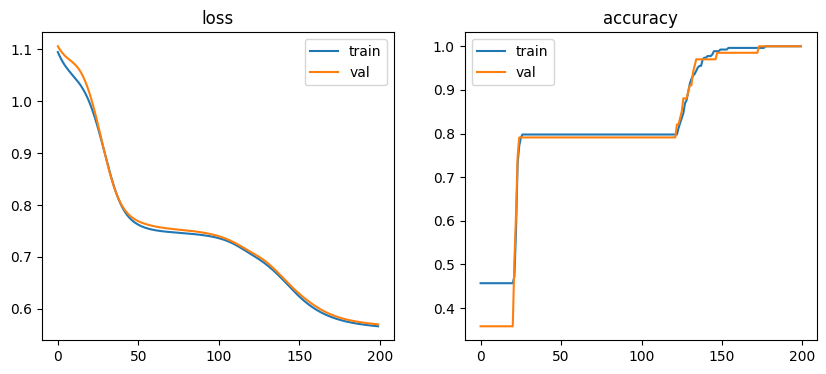

In [39]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 4))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.plot(logs["train_loss"], label="train")
ax0.plot(logs["val_loss"], label="val")
ax0.legend()
ax0.set_title("loss")

ax1.plot(logs["train_acc"], label="train")
ax1.plot(logs["val_acc"], label="val")
ax1.legend()
ax1.set_title("accuracy")
plt.legend()

## 정리

이번 챕터에서는 이론으로만 배웠던 딥러닝을 실제로 구현해보았습니다. 그 결과, 지금까지 우리가 linear regression이나 logistic regression을 Grandient Descent 방식으로 학습시킨 코드와 그다지 다르지 않았습니다. 차이가 있다면 신경망 레이어를 여러 겹 쌓고, 그 사이 사이에 비선형 함수인 sigmoid를 끼워넣은 모델이라는 점입니다. 선형 레이어 사이 사이에 비선형성을 넣어준다는 점을 꼭 기억해주시고 넘어가시기 바랍니다.